In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.util import set_proxy
from nltk import word_tokenize

#set_proxy(proxy = 'http://cache.aut.ac.nz:3128')

sns.set_style("darkgrid")
nltk.download('stopwords')
nltk.download('punkt')

#This loads our raw data, the crawled data from ProgrammableWeb 
df = pd.read_csv('./mashup_rawdata.csv', usecols=[0,1,2,3,4,5,6], \
                 names=['id','name','category','tag','date','desc','api'])
df2 = pd.read_csv('./api_rawdata.csv', usecols=[0,1,2,3,4,5], \
                 names=['id','name','category','tag','date','desc'])


ModuleNotFoundError: No module named 'nltk'

In [2]:
df= df.sort_values('date', ascending=True)
print(df.head(5))

        id                            name category  \
6253  6254                  USA Hot Spring  Mapping   
6299  6300                           Sport  Mapping   
6236  6237             2RealEstate Auction  Mapping   
6297  6298                    UK Traveldat  Mapping   
6238  6239  Williamsburger Community Guide  Mapping   

                                         tag    date  \
6253                             ['Mapping']  2005.1   
6299        ['Mapping', 'Sports', 'England']  2005.1   
6236  ['Mapping', 'Real Estate', 'Auctions']  2005.1   
6297        ['Mapping', 'Travel', 'England']  2005.1   
6238    ['Mapping', 'Food', 'New York City']  2005.1   

                                                   desc  \
6253  Shows you where 1661 hot springs are in the US...   
6299  Lets you find premiership soccer news by team ...   
6236  Live eBay Real Estate listings with Google Map...   
6297  Travel advisories in the UK on a Google Map (w...   
6238  Google Maps mashup helps you fi

In [3]:
#TRAINING SETS and TEST SET
train_df = df[df['date'] < 2016]
validate_df= df[df['date'] >= 2016]

#Whole set
API_count= list(df['api'])
APIs=[int]
for items in API_count:
    if len(items)!=0:
        l=list(items)
        APIs.append(l.count(',')+1)
print ("Number of APIs in the whole dataset: ")
print(APIs[:5])
    
#Training set
API_count_t= list(train_df['api'])
APIs_t=[int]
for items in API_count_t:
    if len(items)!=0:
        l=list(items)
        APIs_t.append(l.count(',')+1)
print ("Number of APIs in training set: ")
print(APIs_t[:5])
    
#Validating set
API_count_v= list(validate_df['api'])
APIs_v=[int]
for items in API_count_v:
    if len(items)!=0:
        l=list(items)
        APIs_v.append(l.count(',')+1)
print ("Number of APIs in validating set: ")
print(APIs_v[:5])
    
###################apis

#count_Tr_APIs_df=Tr_APIs_df.count
print("train_df")
#print(train_df)
print("Length df: ", len(df))
print("Length train_df: ", len(train_df))
print("Length validate_df: ", len(validate_df))
print("Length APIs: ", len(APIs))




Number of APIs in the whole dataset: 
[<class 'int'>, 1, 2, 2, 2]
Number of APIs in training set: 
[<class 'int'>, 1, 2, 2, 2]
Number of APIs in validating set: 
[<class 'int'>, 1, 1, 1, 1]
train_df
Length df:  6340
Length train_df:  6245
Length validate_df:  95
Length APIs:  6341


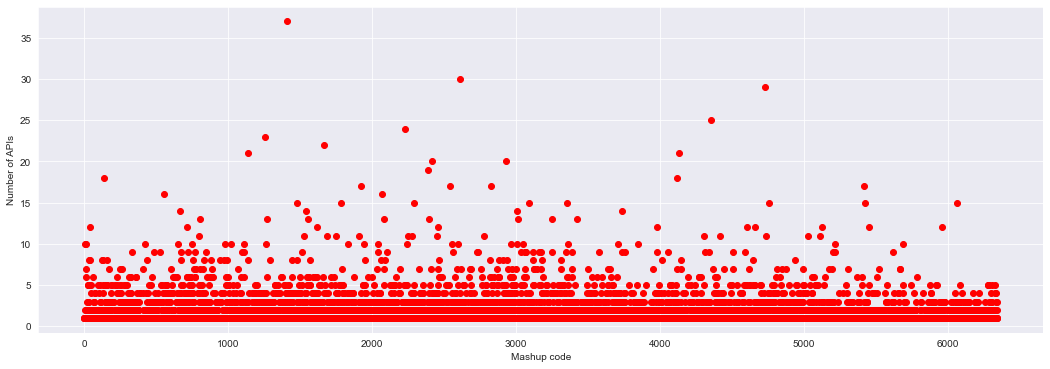

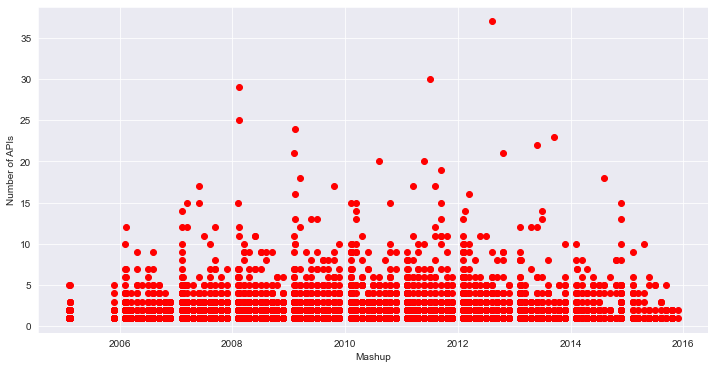

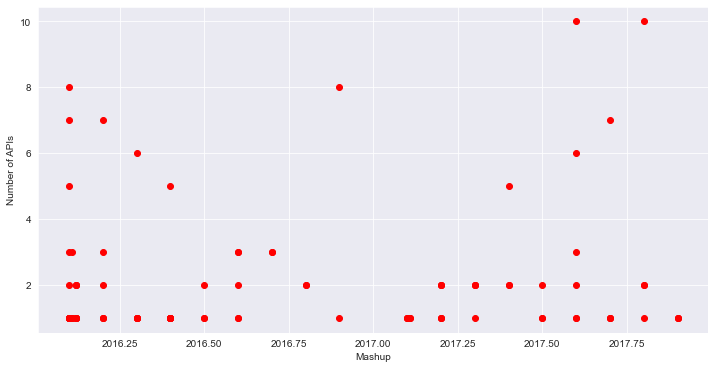

In [4]:
# Show graph
import numpy as n
import matplotlib.pyplot as plt
y_a= APIs[1:]
x_a= df['id']
y_a_t= APIs_t[1:]
x_a_t= train_df['date']
y_a_v= APIs_v[1:]
x_a_v= validate_df['date']
plt.figure(figsize=(18,6))
plt.plot(x_a,y_a, 'ro')
plt.ylabel('Number of APIs')
plt.xlabel('Mashup code')
plt.savefig('./Mo2.eps', format='eps', dpi=1000)
plt.show()
plt.figure(figsize=(12,6))
plt.plot(x_a_t, y_a_t, 'ro')
plt.ylabel('Number of APIs')
plt.xlabel('Mashup')
plt.show()
plt.figure(figsize=(12,6))
plt.plot(x_a_v, y_a_v, 'ro')
plt.ylabel('Number of APIs')
plt.xlabel('Mashup')
plt.show()




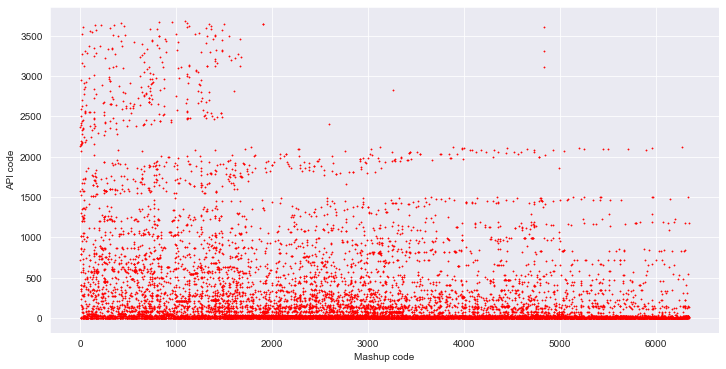

In [5]:
invoc_df = pd.read_csv('./invocation_data.csv', usecols=[0,1,2], \
                 names=['Mashup','API','value'])
x_i= invoc_df['Mashup']
y_i= invoc_df['API']
plt.figure(figsize=(12,6))
#plt.plot(x_i, y_i, 'g^')
plt.ylabel('API code')
plt.xlabel('Mashup code')
plt.scatter(x_i,y_i, s=0.5, c='r', marker='D', alpha=1)
plt.savefig('./Mo1.eps', format='eps', dpi=1000)
plt.show()


In [6]:
df['concat'] = df['id'].astype(str)+'    '+df['desc'].fillna('')
df2['concat'] = df2['id'].astype(str)+'    '+df2['desc'].fillna('')
list_df = df['concat'].fillna('')
list_df2 = df2['concat'].fillna('')
list_df= list_df.values
list_df2= list_df2.values
print(list_df[:3])
print(list_df2[:3])
print('Number of mashups:', len(df))
print('Number of apis:', len(df2))

['6254    Shows you where 1661 hot springs are in the US through NOAA data + Google Maps.'
 '6300    Lets you find premiership soccer news by team location. Via Google Maps and BBC Backstage data.'
 '6237    Live eBay Real Estate listings with Google Maps. Includes USA Top 100 Bid Count List, along with regional Top 50 Lists.']
["1    [This API is no longer available. Google Maps' services have been split into multiple APIs, including the Static Maps API, Street View Image API, Directions APIs, Distance Matrix API, Elevation API, Geocoding API, Geolocation API, Places API, Roads API, and Time Zone API.This page is maintained purely for historical and research purposes.]The Google Maps API allow for the embedding of Google Maps onto web pages of outside developers, using a simple JavaScript interface or a Flash interface. It is designed to work on both mobile devices as well as traditional desktop browser applications. The API includes language localization for over 50 languages, region

In [7]:
#Import all the dependencies

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[int(list_df[i][0:4])]) for i, _d in enumerate(list_df)]
tagged_data2 = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[int(list_df2[i][0:4])]) for i, _d in enumerate(list_df2)]

In [8]:
max_epochs = 20
vec_size = 100
alpha = 0.025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.epochs)
                #epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
Model Saved


In [9]:
max_epochs = 20
vec_size = 100
alpha = 0.025

model2 = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model2.build_vocab(tagged_data2)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model2.train(tagged_data,
                total_examples=model2.corpus_count,
                epochs=model2.epochs)
                #epochs=model.iter)
    # decrease the learning rate
    model2.alpha -= 0.0002
    # fix the learning rate, no decay
    model2.min_alpha = model2.alpha

model2.save("d2v.model2")
print("Model2 Saved")

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
Model2 Saved


In [10]:
from gensim.models.doc2vec import Doc2Vec
# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
#print(model2.docvecs[6236])

In [11]:
from gensim.models.doc2vec import Doc2Vec
model= Doc2Vec.load("d2v.model")
#to find the vector of a mashup which is not in training data
test_data = word_tokenize("Goodneighbor Blockchain ['Artificial Intelligence', 'Social'] Goodneighbor is a platform that allows you to define, run and manage Twitter avatars, totally autonomous Twitter identities that manage their own Twitter accounts, concerned with any subject matter and interested in any topic. ['Twitter', 'Bit.ly']".lower())
v1 = model.infer_vector(test_data)
#print("V1_infer", v1)

# to find most similar APIs using tags
similar_doc = model.docvecs.most_similar(1)
#print("Similar APIs")
#print(similar_doc)

In [12]:
#Finding similarity between 2 documents s_ij in training set
import pandas as pd
from gensim.models import doc2vec
from scipy import spatial
def sim(id_i, id_j):
    veci=model.docvecs[id_i]
    vecj=model2.docvecs[id_j]
    similarity = spatial.distance.cosine(veci, vecj)
    return similarity
print(sim(3,10))

invo_tbl = pd.read_csv('./invocation_data.csv', usecols=[0,1,2], \
                 names=['Mashup','API','Value'])
invo_tbl['Mashup_id']=invo_tbl['Mashup'].astype(int)
invo_tbl['API_id']=invo_tbl['API'].astype(int)
subset = invo_tbl[['Mashup_id', 'API_id']] 
tuples = [tuple(x) for x in subset.values] 
#print(tuples)

invo_tbl['Similarity']= [sim (i,j) for (i,j) in tuples]
print(invo_tbl['Similarity'])
invo_tbl.to_csv('./invocation_data_2.csv', encoding='utf-8', index=False, header=False)

###################apis

0.7517361640930176
0        0.707470
1        0.807997
2        0.736975
3        0.844956
4        0.781394
           ...   
10783    0.631284
10784    0.732462
10785    0.614046
10786    0.895779
10787    0.347743
Name: Similarity, Length: 10788, dtype: float64


In [13]:
#S = np.zeros([5691, 1170])
#for i in train:
#    S[int(ele[0]), int(ele[1])] = float(ele[2])    


In [14]:
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.preprocessing import MinMaxScaler
#import recmetrics
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import time

#-------------------------
# LOAD AND PREP THE DATA
#-------------------------

#The raw mashup-API dataset contains the tuple (mashup_id, API_id, value). 
#A sparse matrix of the dataset is derived after running this code.

raw_data = pd.read_csv('./invocation_data_2.csv', \
            encoding='utf-8', usecols=[0,1,2,5], names=['mashup','api','value','similarity'])
data = raw_data.copy()

#drop duplicate rows
data.drop_duplicates(inplace=True)

#modify the float values of the IDs to be int
data.mashup = data.mashup.astype(int)
data.api = data.api.astype(int)

# Convert api names into numerical IDs
data['mashup_id'] = data['mashup'].astype("category").cat.codes
data['api_id'] = data['api'].astype("category").cat.codes

# Create a lookup frame so we can get the original ids back later.
mashup_lookup = data[['mashup_id', 'mashup']].drop_duplicates()
mashup_lookup['mashup_id'] = mashup_lookup.mashup_id.astype(int)

api_lookup = data[['api_id', 'api']].drop_duplicates()
api_lookup['api_id'] = api_lookup.api_id.astype(int)

# Create lists of all mashups, apis and values
mashups = list(np.sort(data.mashup_id.unique()))
apis = list(np.sort(data.api_id.unique()))
values = list(data.value)
similarity= list(data.similarity)

# Get the rows and columns for our new matrix
rows = data.mashup_id.astype(int)
cols = data.api_id.astype(int)
print(len(apis))
 
# Contruct a sparse matrix for our mashups and apis containing the preference score(at the moment the sim)
data_sparse = sparse.csr_matrix((values, (rows, cols)), shape=(len(mashups), len(apis)))
den_data_sparse = data_sparse.toarray()
#print(den_data_sparse[1][2:10])
sim_matrix= sparse.csr_matrix((similarity, (rows, cols)), shape=(len(mashups), len(apis)))

matrix_size = data_sparse.shape[0]*data_sparse.shape[1] # Number of possible interactions in the matrix
num_interactions = len(data_sparse.nonzero()[0]) # Number of mashup-api interactions
sparsity = 100*(1 - (len(data)/matrix_size))

den_sim= sim_matrix.toarray()
api_sim_matrix= sparse.csr_matrix((similarity, (cols, cols)), shape=(len(apis), len(apis)))
#print(api_sim_matrix)
api_sim=api_sim_matrix.toarray()

#print("Matrix size: %d x %d = %d" % (len(mashups),len(apis),matrix_size))
#print("Number of mashup-api interactions: ",num_interactions) #this is equivalent to the length of data 
#print("Sparsity:", sparsity)


1170


In [15]:

#for i in range(1,len(mashups)):
#    for j in range(1,len(apis)):
#        print(den_sim_matrix[i][j])
inrow=0
for k in mashups:
    
    incol=0
    for l in apis:
        den_sim[inrow][incol]=sim(k,l)
        #print(den_sim[inrow][incol])
        incol=incol+ 1
    inrow= inrow +1
print(den_sim[:10][:10])

[[0.         1.09485318 1.08218087 ... 0.97210355 1.1113648  1.15557328]
 [0.96244967 0.34123838 0.93505416 ... 0.9708848  0.83825871 0.98248118]
 [1.13770296 0.91383583 0.33664227 ... 0.76383431 0.78161821 0.69645682]
 ...
 [0.88746576 0.93402336 0.78568983 ... 0.76321928 0.6566771  0.74263343]
 [1.06258509 0.81400974 0.76518393 ... 0.73815519 0.87141852 0.70462221]
 [0.94081997 0.88415083 0.80659303 ... 0.87733424 0.71671745 0.66258225]]


In [16]:


#print(api_sim)
inrow=0
for i in apis:
    incol=0
    for k in apis:
        api_sim[inrow][incol]=sim(i,k)
        incol=incol+1
    inrow=inrow +1
print(api_sim[:10][:10])


                
                
#api_f_matrix= sparse.csr_matrix((similarity, (cols, cols)), shape=(len(apis), len(apis)))
#api_f=api_f_matrix.toarray()




[[0.         1.09485318 1.08218087 ... 0.97210355 1.1113648  1.15557328]
 [0.96244967 0.34123838 0.93505416 ... 0.9708848  0.83825871 0.98248118]
 [1.13770296 0.91383583 0.33664227 ... 0.76383431 0.78161821 0.69645682]
 ...
 [0.88746576 0.93402336 0.78568983 ... 0.76321928 0.6566771  0.74263343]
 [1.06258509 0.81400974 0.76518393 ... 0.73815519 0.87141852 0.70462221]
 [0.94081997 0.88415083 0.80659303 ... 0.87733424 0.71671745 0.66258225]]


In [17]:
api_f=np.zeros((len(apis),len(apis)))

#for k in mashups:
#    for l in apis:
#        for h in apis:
#            if (den_data_sparse[k][l]==1) and (den_data_sparse[k][h]==1):
#                api_f[l][h]+=1
 #               print(api_f[l][h])


In [18]:
import pandas as pd
pd.DataFrame(api_sim).to_csv('./api_sim.csv', encoding='utf-8', index=False, header=False)
pd.DataFrame(den_sim).to_csv('./den_sim.csv', encoding='utf-8', index=False, header=False)

#pd.DataFrame(api_f).to_csv('C:/Users/thinguyen/Desktop/PHD Semestor 2/Virtual_PC/bk/Python code/Doc2Vec_API_Mo/api_f.csv', encoding='utf-8', index=False, header=False)


In [19]:

import csv
import numpy as np
import matplotlib.pyplot as plt

data_path = './api_f.csv'
with open(data_path, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    # get header from first row
    #headers = next(reader)
    # get all the rows as a list
    data = list(reader)
    # transform data into numpy array
    data = np.array(data).astype(float)
api_f=data    
#rint(data)
api_f.shape
#

#



(1170, 1170)

In [20]:
print(api_f)

[[  0.   0. 151. ...   0.   1.   1.]
 [  0.   0.   0. ...   0.   0.   0.]
 [151.   0.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  1.   0.   0. ...   0.   0.   0.]
 [  1.   0.   0. ...   0.   0.   0.]]


In [21]:
data_path2 = './api_sim.csv'
with open(data_path2, 'r') as f2:
    reader2 = csv.reader(f2, delimiter=',')
    # get header from first row
    #headers = next(reader)
    # get all the rows as a list
    data2 = list(reader2)
   # transform data into numpy array
    data2 = np.array(data2).astype(float)
api_sim=data2    
#rint(data)
api_sim.shape
print(api_sim)

[[0.         1.09485318 1.08218087 ... 0.97210355 1.1113648  1.15557328]
 [0.96244967 0.34123838 0.93505416 ... 0.9708848  0.83825871 0.98248118]
 [1.13770296 0.91383583 0.33664227 ... 0.76383431 0.78161821 0.69645682]
 ...
 [0.94866931 0.96954222 0.8635658  ... 0.35433382 0.82250597 0.79832737]
 [1.06870277 0.93770101 0.67561319 ... 0.93289138 0.39541709 0.64892313]
 [1.15554671 0.91367248 0.6102137  ... 0.59589303 0.58841571 0.29787588]]


In [22]:
data_path3 = './den_sim.csv'
with open(data_path3, 'r') as f3:
    reader3 = csv.reader(f3, delimiter=',')
    # get header from first row
    #headers = next(reader)
    # get all the rows as a list
    data3 = list(reader3)
    # transform data into numpy array
    data3 = np.array(data3).astype(float)
den_sim=data3    
#rint(data)
den_sim.shape

(5691, 1170)

In [23]:
print(den_sim)

[[0.         1.09485318 1.08218087 ... 0.97210355 1.1113648  1.15557328]
 [0.96244967 0.34123838 0.93505416 ... 0.9708848  0.83825871 0.98248118]
 [1.13770296 0.91383583 0.33664227 ... 0.76383431 0.78161821 0.69645682]
 ...
 [1.09498674 0.80785069 0.86504766 ... 0.76641683 0.80375017 0.57600415]
 [0.98022917 0.84531695 0.66509587 ... 0.78424968 0.85332957 0.71471915]
 [0.93477887 0.83607963 0.72767907 ... 1.00111649 0.62701651 0.70454389]]


In [24]:
import math
from scipy.special import factorial
api_Re=np.zeros((len(apis),len(apis)))
#Weibull
temp=np.exp(-(api_f/31.522)**0.59726)
api_Re= ((0.59726/31.522)*((api_f/31.522)**(-0.59726)))*temp
#Exponential
#lamda= 0.00453
#api_Re= lamda*np.exp(-lamda*api_f)

#print(api_Re[len(apis)-1][len(apis)-1])
sum_api_Re=np.sum(api_Re)
print(sum_api_Re)
#api_Re= lamda*api_sim + (1- lamda)* (1- 1/(math.exp(api_f)))

inf


c:\anaconda3\envs\python3.6.10\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in power
  


In [25]:
#Creates a train set by masking a certain percentage of the actual data
import random

data_seed = 0

def make_train(ratings, pct_test = 0.2):
    '''
    This function will take in the original user-item matrix and "mask" a percentage of the original ratings 
    where a user-item interaction has taken place for use as a test set. The test set will contain all 
    of the original ratings, while the training set replaces the specified percentage of them with a 
    zero in the original ratings matrix. 
    
    parameters: 
    
    ratings - the original ratings matrix from which you want to generate a train/test set. Test is just a complete
    copy of the original set. This is in the form of a sparse csr_matrix. 
    
    pct_test - The percentage of user-item interactions where an interaction took place that you want to mask in the 
    training set for later comparison to the test set, which contains all of the original ratings. 
    
    returns:
    
    training_set - The altered version of the original data with a certain percentage of the user-item pairs 
    that originally had interaction set back to zero.
    
    test_set - A copy of the original ratings matrix, unaltered, so it can be used to see how the rank order 
    compares with the actual interactions.
    
    user_inds - From the randomly selected user-item indices, which user rows were altered in the training data.
    This will be necessary later when evaluating the performance via AUC.
    '''
    test_set = ratings.copy() # Make a copy of the original dataset to be the test set. 
        
    training_set = ratings.copy() # Make a copy of the original dataset we can alter as our training set. 
          
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of user,item index into list
    random.seed(data_seed) # Set the random seed for reproducibility
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of user-item pairs without replacement
    user_inds = [index[0] for index in samples] # Get the user row indices
    item_inds = [index[1] for index in samples] # Get the item column indices
    training_set[user_inds, item_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    return training_set, test_set, list(set(user_inds)), user_inds, item_inds # Output the unique list of user rows that were altered 

train_data, test_data, mashup_rows_altered, mashup_inds, api_inds = make_train(data_sparse)

In [26]:
#print(train_data[1:])
#print(num_samples)
#print(test_data[1:])
#invo_tbl['Mashup_id']=invo_tbl['Mashup'].astype(int)
#invo_tbl['API_id']=invo_tbl['API'].astype(int)
#subset = invo_tbl[['Mashup_id', 'API_id']] 
#tuples = [tuple(x) for x in train_data[0]] 
#print(tuples)

#Dotuongquan= [sim (i,j) for (i,j) in tuples]
#print(Dotuongquan)

In [27]:
#PMF CONREL
from gensim.models import doc2vec
from scipy import spatial
import numpy as np
from numpy.random import RandomState
import pickle
import os
import copy

def RMSE2(preds, truth):
        return np.sqrt(np.mean(np.square(preds-truth)))
def calc_rmse(prediction, m_inds, a_inds, test_data):
    '''
    This function will calculate the RMSE given the test set. 
    
    parameters:
    
    m_inds, a_inds - the indeces of the test values (the masked values in make_train) 
    
    prediction - The calculated ratings as output from the user- or item-based similarity prediction.
        
    test_data - The test set constucted earlier from make_train function
        
    returns:
    RMSE and MAE of the test_data
    
    '''    
    rows, cols = m_inds, a_inds        
    
    R = np.array(test_data[rows, cols]) # get the list of masked values from the test_data (actual data)
    R_hat = np.array(prediction[rows, cols]) # get the list of prediction for the masked values           
    
    rmse_val = np.sqrt(((R_hat - R)**2).mean()) # compute the RMSE     
    mae_val  = np.absolute((R_hat - R)).mean()  # compute MAE
    
    return float('%.4f' % rmse_val), float('%.4f' % mae_val)  

class PMF2():
    '''
    a class for this Double Co-occurence Factorization model
    '''
    # initialize some paprameters
    def __init__(self, R, lambda_alpha=1e-2, lambda_beta=1e-2, latent_size=20, momuntum=0.8,
                 lr=0.001, iters=1000, seed=None):
        self.lambda_alpha = lambda_alpha
        self.lambda_beta = lambda_beta
        self.momuntum = momuntum
        self.R = R 
        self.random_state = RandomState(seed)
        self.iterations = iters
        self.lr = lr
        self.I = copy.deepcopy(self.R)
        self.I[self.I != 0] = 1 #this is for the I_ij indicator function that is equal to 1 when user i rated item j, 0 otherwise           
        
        #initialize the latent feature matrices U and V with a normally distributed random values
        self.M = 0.1*self.random_state.rand(np.size(R, 0), latent_size)
        self.A = 0.1*self.random_state.rand(np.size(R, 1), latent_size)

    def loss(self):
        # the loss function of the model
        loss = np.sum(self.I*(self.R-den_sim*np.dot(self.M, self.A.T))**2) + self.lambda_alpha*np.sum(np.square(self.M)) + self.lambda_beta*np.sum(np.square(self.A))
        return loss
    def predict(self, data):
        index_data = np.array([[int(ele[0]), int(ele[1])] for ele in data], dtype=int)        
        m_features = self.M.take(index_data.take(0, axis=1), axis=0)        
        a_features = self.A.take(index_data.take(1, axis=1), axis=0)        
        preds_value_array = np.sum(m_features*a_features, 1)        
        return preds_value_array
     
    def train(self, train_data=None, vali_data=None):
        '''
        # training process
        :param train_data: train data with [[i,j],...] and this indicates that K[i,j]=rating
        :param lr: learning rate
        :param iterations: number of iterations
        :return: learned V, T and loss_list during iterations
        '''
        #prints the number of 0 or 1 in I
        #print(np.count_nonzero(self.I == 0))
        #print(np.count_nonzero(self.I == 1))
             
        train_loss_list = []
        vali_rmse_list = []
        last_vali_rmse = 10000

        #initilize matrices with the same dimensions as M and A 
        temp_M = np.zeros(self.M.shape) 
        temp_A = np.zeros(self.A.shape)              
                
        for it in range(self.iterations):
            # derive gradients
            grads_m = np.dot(self.I*(self.R-den_sim*np.dot(self.M, self.A.T)), -self.A) + self.lambda_alpha*self.M                   
            
            grads_a = np.dot((self.I*(self.R-den_sim*np.dot(self.M, self.A.T))).T, -self.M) + self.lambda_beta*self.A

            # update the parameters with momentum
            temp_M = (self.momuntum * temp_M) + self.lr * grads_m
            temp_A = (self.momuntum * temp_A) + self.lr * grads_a
            
            self.M = self.M - temp_M
            self.A = self.A - temp_A

            # training evaluation
            train_loss = self.loss()
            train_loss_list.append(train_loss)
            
            #uses the train data to compute rmse
            vali_preds = self.predict(train_data)
            vali_rmse = RMSE2(train_data[:,2], vali_preds)
            vali_rmse_list.append([it+1,vali_rmse])                  
            
            #uses the validation data to compute rmse
            #vali_preds = self.predict(vali_data)
            #vali_rmse = RMSE2(vali_data[:,2], vali_preds)
            #vali_rmse_list.append(it+1,vali_rmse)
                        
            print('training iteration:{: d} ,loss:{: f}, vali_rmse:{: f}'.format(it+1, train_loss, vali_rmse))
            #setting the convergence
            if (abs(last_vali_rmse - vali_rmse)) <= 0.000001:
                print('convergence at iterations:{: d}'.format(it+1))
            #    break
            else:
                last_vali_rmse = vali_rmse

        return self.M, self.A, train_loss_list, vali_rmse_list

    
dense_train = train_data.todense()  

dense_train = dense_train.astype(float) #sets the type of array to float

sparse_train = sparse.csr_matrix(dense_train) 
c = sparse_train.tocoo()

###In order to let PMF predict all values of R, we set all r[i][j] = 1. Hence, the sparse matrix will involve every mashup-api interaction. 
dense_test = test_data.todense()  
dense_test[dense_test != 1] = 1 #changes the zero train data to 1 
sparse_test = sparse.csr_matrix(dense_test) 
t = sparse_test.tocoo()

r1 = np.array(c.row, dtype=np.int64)
c1 = np.array(c.col, dtype=np.int64)
d1 = np.array(c.data, dtype=np.int64)
train = np.stack((r1,c1,d1),axis=-1)

#print(train)

r2 = np.array(t.row, dtype=np.int64)
c2 = np.array(t.col, dtype=np.int64)
d2 = np.array(t.data, dtype=np.int64)
test = np.stack((r2,c2,d2),axis=-1)

#print(test)
    
R = np.zeros([5691, 1170])
for ele in train:
    R[int(ele[0]), int(ele[1])] = float(ele[2])

#S = np.zeros([5691, 1170])
#for i in train:
#    S[int(ele[0]), int(ele[1])] = sim(int(ele[0]), int(ele[1])) 
    
# construct model
#print('training model.......')
test = test_data.copy()
test[test != 0] = 1 #change test_data to binary matrix, but our data is already binary anyway
lambda_alpha = 0.1
lambda_beta = 0.1
latent_size = 20
lr = 0.0005
iters=500
model = PMF2(R=R, lambda_alpha=lambda_alpha, lambda_beta=lambda_beta, latent_size=latent_size, momuntum=0.9, lr=lr, iters=iters)
#print('parameters are:reg_u={:f}, reg_v={:f}, latent_size={:d}, lr={:f}, iters={:d}'.format(lambda_alpha, lambda_beta, latent_size,lr, iters))
M, A, train_loss_list, vali_rmse_list = model.train(train_data=train)
pmf2_pred = M.dot(A.transpose())
print("ConRel : ",vali_rmse_list[-1], calc_rmse(pmf2_pred, mashup_inds, api_inds, test))


training iteration: 1 ,loss: 7810.420790, vali_rmse: 0.941361
training iteration: 2 ,loss: 7532.794156, vali_rmse: 0.923328
training iteration: 3 ,loss: 7177.785862, vali_rmse: 0.899483
training iteration: 4 ,loss: 6790.605807, vali_rmse: 0.872287
training iteration: 5 ,loss: 6411.660825, vali_rmse: 0.844153
training iteration: 6 ,loss: 6072.613596, vali_rmse: 0.817250
training iteration: 7 ,loss: 5793.767305, vali_rmse: 0.793292
training iteration: 8 ,loss: 5582.249676, vali_rmse: 0.773305
training iteration: 9 ,loss: 5431.352525, vali_rmse: 0.757426
training iteration: 10 ,loss: 5322.151392, vali_rmse: 0.744885
training iteration: 11 ,loss: 5228.344332, vali_rmse: 0.734266
training iteration: 12 ,loss: 5123.832371, vali_rmse: 0.724013
training iteration: 13 ,loss: 4990.672389, vali_rmse: 0.713002
training iteration: 14 ,loss: 4824.147708, vali_rmse: 0.700936
training iteration: 15 ,loss: 4632.806174, vali_rmse: 0.688411
training iteration: 16 ,loss: 4433.830071, vali_rmse: 0.676642
t

training iteration: 131 ,loss: 1206.669492, vali_rmse: 0.386562
training iteration: 132 ,loss: 1199.131987, vali_rmse: 0.385590
training iteration: 133 ,loss: 1191.681730, vali_rmse: 0.384622
training iteration: 134 ,loss: 1184.317154, vali_rmse: 0.383661
training iteration: 135 ,loss: 1177.036776, vali_rmse: 0.382707
training iteration: 136 ,loss: 1169.839186, vali_rmse: 0.381762
training iteration: 137 ,loss: 1162.723001, vali_rmse: 0.380826
training iteration: 138 ,loss: 1155.686792, vali_rmse: 0.379901
training iteration: 139 ,loss: 1148.729061, vali_rmse: 0.378987
training iteration: 140 ,loss: 1141.848265, vali_rmse: 0.378087
training iteration: 141 ,loss: 1135.042886, vali_rmse: 0.377199
training iteration: 142 ,loss: 1128.311517, vali_rmse: 0.376324
training iteration: 143 ,loss: 1121.652925, vali_rmse: 0.375463
training iteration: 144 ,loss: 1115.066056, vali_rmse: 0.374615
training iteration: 145 ,loss: 1108.550003, vali_rmse: 0.373779
training iteration: 146 ,loss: 1102.1039

training iteration: 261 ,loss: 670.225361, vali_rmse: 0.321652
training iteration: 262 ,loss: 668.208167, vali_rmse: 0.321449
training iteration: 263 ,loss: 666.209734, vali_rmse: 0.321248
training iteration: 264 ,loss: 664.229870, vali_rmse: 0.321050
training iteration: 265 ,loss: 662.268388, vali_rmse: 0.320855
training iteration: 266 ,loss: 660.325101, vali_rmse: 0.320662
training iteration: 267 ,loss: 658.399826, vali_rmse: 0.320472
training iteration: 268 ,loss: 656.492380, vali_rmse: 0.320284
training iteration: 269 ,loss: 654.602583, vali_rmse: 0.320099
training iteration: 270 ,loss: 652.730257, vali_rmse: 0.319916
training iteration: 271 ,loss: 650.875224, vali_rmse: 0.319736
training iteration: 272 ,loss: 649.037311, vali_rmse: 0.319558
training iteration: 273 ,loss: 647.216343, vali_rmse: 0.319383
training iteration: 274 ,loss: 645.412151, vali_rmse: 0.319210
training iteration: 275 ,loss: 643.624564, vali_rmse: 0.319039
training iteration: 276 ,loss: 641.853415, vali_rmse: 0

training iteration: 392 ,loss: 514.624044, vali_rmse: 0.309966
training iteration: 393 ,loss: 513.993375, vali_rmse: 0.309950
training iteration: 394 ,loss: 513.368165, vali_rmse: 0.309935
training iteration: 395 ,loss: 512.748369, vali_rmse: 0.309920
training iteration: 396 ,loss: 512.133945, vali_rmse: 0.309906
training iteration: 397 ,loss: 511.524848, vali_rmse: 0.309892
training iteration: 398 ,loss: 510.921035, vali_rmse: 0.309880
training iteration: 399 ,loss: 510.322464, vali_rmse: 0.309868
training iteration: 400 ,loss: 509.729093, vali_rmse: 0.309856
training iteration: 401 ,loss: 509.140879, vali_rmse: 0.309845
training iteration: 402 ,loss: 508.557783, vali_rmse: 0.309835
training iteration: 403 ,loss: 507.979762, vali_rmse: 0.309826
training iteration: 404 ,loss: 507.406776, vali_rmse: 0.309817
training iteration: 405 ,loss: 506.838786, vali_rmse: 0.309809
training iteration: 406 ,loss: 506.275750, vali_rmse: 0.309801
training iteration: 407 ,loss: 505.717630, vali_rmse: 0

In [28]:
#RMSE and MAE
def calc_rmse(prediction, m_inds, a_inds, test_data):
    '''
    This function will calculate the RMSE given the test set. 
    
    parameters:
    
    m_inds, a_inds - the indeces of the test values (the masked values in make_train) 
    
    prediction - The calculated ratings as output from the user- or item-based similarity prediction.
        
    test_data - The test set constucted earlier from make_train function
        
    returns:
    RMSE and MAE of the test_data
    
    '''    
    rows, cols = m_inds, a_inds        
    
    R = np.array(test_data[rows, cols]) # get the list of masked values from the test_data (actual data)
    R_hat = np.array(prediction[rows, cols]) # get the list of prediction for the masked values           
    
    rmse_val = np.sqrt(((R_hat - R)**2).mean()) # compute the RMSE     
    mae_val  = np.absolute((R_hat - R)).mean()  # compute MAE
    
    return float('%.4f' % rmse_val), float('%.4f' % mae_val)  
   
#CALCULATE RMSE and MAE of test_data
test = test_data.copy()
test[test != 0] = 1 #change test_data to binary matrix, but our data is already binary anyway



print("ConRel : ", calc_rmse(pmf2_pred, mashup_inds, api_inds, test))


ConRel :  (0.546, 0.4656)


In [29]:
#print(vali_rmse_list)
#pd.DataFrame(vali_rmse_list).to_csv("C:/Users/thinguyen/Desktop/PHD Semestor 2/Virtual_PC/PyRun/RMSE_list1.csv")

In [30]:
#CONREL+
from gensim.models import doc2vec
from scipy import spatial
import numpy as np
from numpy.random import RandomState
import pickle
import os
import copy

def RMSE2(preds, truth):
        return np.sqrt(np.mean(np.square(preds-truth)))
def calc_rmse(prediction, m_inds, a_inds, test_data):
    '''
    This function will calculate the RMSE given the test set. 
    
    parameters:
    
    m_inds, a_inds - the indeces of the test values (the masked values in make_train) 
    
    prediction - The calculated ratings as output from the user- or item-based similarity prediction.
        
    test_data - The test set constucted earlier from make_train function
        
    returns:
    RMSE and MAE of the test_data
    
    '''    
    rows, cols = m_inds, a_inds        
    
    R = np.array(test_data[rows, cols]) # get the list of masked values from the test_data (actual data)
    R_hat = np.array(prediction[rows, cols]) # get the list of prediction for the masked values           
    
    rmse_val = np.sqrt(((R_hat - R)**2).mean()) # compute the RMSE     
    mae_val  = np.absolute((R_hat - R)).mean()  # compute MAE
    
    return float('%.4f' % rmse_val), float('%.4f' % mae_val)  

class PMF2C():
    '''
    a class for this Double Co-occurence Factorization model
    '''
    # initialize some paprameters
    def __init__(self, R, gamma=1e-2, lambda_alpha=1e-2, lambda_beta=1e-2, latent_size=20, momuntum=0.8,
                 lr=0.001, iters=1000, seed=None):
        self.lambda_alpha = lambda_alpha
        self.lambda_beta = lambda_beta
        self.gamma = gamma
        self.momuntum = momuntum
        self.R = R 
        self.random_state = RandomState(seed)
        self.iterations = iters
        self.lr = lr
        self.I = copy.deepcopy(self.R)
        self.I[self.I != 0] = 1 #this is for the I_ij indicator function that is equal to 1 when user i rated item j, 0 otherwise           
        
        #initialize the latent feature matrices U and V with a normally distributed random values
        self.M = 0.1*self.random_state.rand(np.size(R, 0), latent_size)
        self.A = 0.1*self.random_state.rand(np.size(R, 1), latent_size)

    def loss(self):
        # the loss function of the model
        loss = np.sum(self.I*(self.R-den_sim*np.dot(self.M, self.A.T))**2) + self.gamma*np.sum(np.square(self.A-(np.dot(api_Re,self.A))*(1/sum_api_Re)))+ self.lambda_alpha*np.sum(np.square(self.M)) + self.lambda_beta*np.sum(np.square(self.A))
        return loss
    def predict(self, data):
        index_data = np.array([[int(ele[0]), int(ele[1])] for ele in data], dtype=int)        
        m_features = self.M.take(index_data.take(0, axis=1), axis=0)        
        a_features = self.A.take(index_data.take(1, axis=1), axis=0)        
        preds_value_array = np.sum(m_features*a_features, 1)        
        return preds_value_array
     
    def train(self, train_data=None, vali_data=None):
        '''
        # training process
        :param train_data: train data with [[i,j],...] and this indicates that K[i,j]=rating
        :param lr: learning rate
        :param iterations: number of iterations
        :return: learned V, T and loss_list during iterations
        '''
        #prints the number of 0 or 1 in I
        #print(np.count_nonzero(self.I == 0))
        #print(np.count_nonzero(self.I == 1))
             
        train_loss_list = []
        vali_rmse_list = []
        last_vali_rmse = 1000

        #initilize matrices with the same dimensions as M and A 
        temp_M = np.zeros(self.M.shape) 
        temp_A = np.zeros(self.A.shape)              
                
        for it in range(self.iterations):
            # derive gradients
            grads_m = np.dot(self.I*(self.R-den_sim*np.dot(self.M, self.A.T)), -self.A) + self.lambda_alpha*self.M                   
            
            grads_a = np.dot((self.I*(self.R-den_sim*np.dot(self.M, self.A.T))).T, -self.M) + self.lambda_beta*self.A 
            + (self.gamma-self.gamma/sum_api_Re)*(self.A-((np.dot(api_Re,self.A))*(1/sum_api_Re)))
            # update the parameters with momentum
            temp_M = (self.momuntum * temp_M) + self.lr * grads_m
            temp_A = (self.momuntum * temp_A) + self.lr * grads_a
            
            self.M = self.M - temp_M
            self.A = self.A - temp_A

            # training evaluation
            train_loss = self.loss()
            train_loss_list.append(train_loss)
            
            #uses the train data to compute rmse
            vali_preds = self.predict(train_data)
            vali_rmse = RMSE2(train_data[:,2], vali_preds)
            vali_rmse_list.append([it+1,vali_rmse])                  
            
                      
            #print('training iteration:{: d} ,loss:{: f}, vali_rmse:{: f}'.format(it+1, train_loss, vali_rmse))
             #setting the convergence
            if (abs(last_vali_rmse - vali_rmse)) <= 0.000001:
                #print('convergence at iterations:{: d}'.format(it+1))
                break
            else:
                last_vali_rmse = vali_rmse

        return self.M, self.A, train_loss_list, vali_rmse_list

    
dense_train = train_data.todense()  

dense_train = dense_train.astype(float) #sets the type of array to float

sparse_train = sparse.csr_matrix(dense_train) 
c = sparse_train.tocoo()

###In order to let PMF predict all values of R, we set all r[i][j] = 1. Hence, the sparse matrix will involve every mashup-api interaction. 
dense_test = test_data.todense()  
dense_test[dense_test != 1] = 1 #changes the zero train data to 1 
sparse_test = sparse.csr_matrix(dense_test) 
t = sparse_test.tocoo()

r1 = np.array(c.row, dtype=np.int64)
c1 = np.array(c.col, dtype=np.int64)
d1 = np.array(c.data, dtype=np.int64)
train = np.stack((r1,c1,d1),axis=-1)

#print(train)

r2 = np.array(t.row, dtype=np.int64)
c2 = np.array(t.col, dtype=np.int64)
d2 = np.array(t.data, dtype=np.int64)
test = np.stack((r2,c2,d2),axis=-1)

#print(test)
    
R = np.zeros([5691, 1170])
for ele in train:
    R[int(ele[0]), int(ele[1])] = float(ele[2])

#S = np.zeros([5691, 1170])
#for i in train:
#    S[int(ele[0]), int(ele[1])] = sim(int(ele[0]), int(ele[1])) 
    
# construct model
#print('training model.......')
test = test_data.copy()
test[test != 0] = 1 
lambda_alpha = 0.1
lambda_beta = 0.1
latent_size = 20
lr = 0.0005
for iters in range(5,500,5):
    model = PMF2C(R=R, lambda_alpha=lambda_alpha, lambda_beta=lambda_beta, latent_size=latent_size, momuntum=0.9, lr=lr, iters=iters)
    #print('parameters are:reg_u={:f}, reg_v={:f}, latent_size={:d}, lr={:f}, iters={:d}'.format(lambda_alpha, lambda_beta, latent_size,lr, iters))
    M, A, train_loss_list, vali_rmse_list = model.train(train_data=train)
    pmf2c_pred = M.dot(A.transpose())
    print("ConRel+ : ",vali_rmse_list[-1], calc_rmse(pmf2c_pred, mashup_inds, api_inds, test))

c:\anaconda3\envs\python3.6.10\lib\site-packages\ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in multiply
c:\anaconda3\envs\python3.6.10\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in multiply


ConRel+ :  [5, 0.8447816794374072] (0.8399, 0.8212)
ConRel+ :  [10, 0.7454430739398443] (0.742, 0.6733)
ConRel+ :  [15, 0.6894066830288845] (0.6938, 0.6133)
ConRel+ :  [20, 0.6590178118002709] (0.6562, 0.5535)
ConRel+ :  [25, 0.6695217235958919] (0.6509, 0.554)
ConRel+ :  [30, 0.6414570770272083] (0.6334, 0.5373)
ConRel+ :  [35, 0.5978226971689915] (0.6158, 0.5138)
ConRel+ :  [40, 0.5639407604367177] (0.5991, 0.4932)
ConRel+ :  [45, 0.536553419885632] (0.5844, 0.4785)
ConRel+ :  [50, 0.5198626856234102] (0.5729, 0.4702)
ConRel+ :  [55, 0.5115390277841806] (0.5689, 0.4685)
ConRel+ :  [60, 0.5002072927771295] (0.5659, 0.4681)
ConRel+ :  [65, 0.48809260077926686] (0.5588, 0.4619)
ConRel+ :  [70, 0.47506197721788124] (0.5537, 0.4598)
ConRel+ :  [75, 0.46377227240832025] (0.5442, 0.4512)
ConRel+ :  [80, 0.45352621629828] (0.5408, 0.4512)
ConRel+ :  [85, 0.44524043724255485] (0.5386, 0.451)
ConRel+ :  [90, 0.43770409887691925] (0.5332, 0.4452)
ConRel+ :  [95, 0.42948439487606166] (0.532, 0.4

KeyboardInterrupt: 

## API_Rel

In [126]:
#API-Rel
from gensim.models import doc2vec
from scipy import spatial
import numpy as np
from numpy.random import RandomState
import pickle
import os
import copy

def RMSE2(preds, truth):
        return np.sqrt(np.mean(np.square(preds-truth)))
def calc_rmse(prediction, m_inds, a_inds, test_data):
    '''
    This function will calculate the RMSE given the test set. 
    
    parameters:
    
    m_inds, a_inds - the indeces of the test values (the masked values in make_train) 
    
    prediction - The calculated ratings as output from the user- or item-based similarity prediction.
        
    test_data - The test set constucted earlier from make_train function
        
    returns:
    RMSE and MAE of the test_data
    
    '''    
    rows, cols = m_inds, a_inds        
    
    R = np.array(test_data[rows, cols]) # get the list of masked values from the test_data (actual data)
    R_hat = np.array(prediction[rows, cols]) # get the list of prediction for the masked values           
    
    rmse_val = np.sqrt(((R_hat - R)**2).mean()) # compute the RMSE     
    mae_val  = np.absolute((R_hat - R)).mean()  # compute MAE
    
    return float('%.4f' % rmse_val), float('%.4f' % mae_val) 
class PMF2CA():
    '''
    a class for this Double Co-occurence Factorization model
    '''
    # initialize some paprameters
    def __init__(self, R, gamma=1e-2, lambda_alpha=1e-2, lambda_beta=1e-2, latent_size=20, momuntum=0.8,
                 lr=0.001, iters=1000, seed=None):
        self.lambda_alpha = lambda_alpha
        self.lambda_beta = lambda_beta
        self.gamma = gamma
        self.momuntum = momuntum
        self.R = R 
        self.random_state = RandomState(seed)
        self.iterations = iters
        self.lr = lr
        self.I = copy.deepcopy(self.R)
        self.I[self.I != 0] = 1 #this is for the I_ij indicator function that is equal to 1 when user i rated item j, 0 otherwise           
        
        #initialize the latent feature matrices U and V with a normally distributed random values
        self.M = 0.1*self.random_state.rand(np.size(R, 0), latent_size)
        self.A = 0.1*self.random_state.rand(np.size(R, 1), latent_size)

    def loss(self):
        # the loss function of the model
        loss = np.sum(self.I*(self.R-np.dot(self.M, self.A.T))**2) + self.gamma*np.sum(np.square(self.A-(np.dot(api_Re,self.A))*(1/sum_api_Re)))+ self.lambda_alpha*np.sum(np.square(self.M)) + self.lambda_beta*np.sum(np.square(self.A))
        return loss
    def predict(self, data):
        index_data = np.array([[int(ele[0]), int(ele[1])] for ele in data], dtype=int)        
        m_features = self.M.take(index_data.take(0, axis=1), axis=0)        
        a_features = self.A.take(index_data.take(1, axis=1), axis=0)        
        preds_value_array = np.sum(m_features*a_features, 1)        
        return preds_value_array
     
    def train(self, train_data=None, vali_data=None):
        '''
        # training process
        :param train_data: train data with [[i,j],...] and this indicates that K[i,j]=rating
        :param lr: learning rate
        :param iterations: number of iterations
        :return: learned V, T and loss_list during iterations
        '''
        #prints the number of 0 or 1 in I
        #print(np.count_nonzero(self.I == 0))
        #print(np.count_nonzero(self.I == 1))
             
        train_loss_list = []
        vali_rmse_list = []
        last_vali_rmse = 1000

        #initilize matrices with the same dimensions as M and A 
        temp_M = np.zeros(self.M.shape) 
        temp_A = np.zeros(self.A.shape)              
                
        for it in range(self.iterations):
            # derive gradients
            grads_m = np.dot(self.I*(self.R-den_sim*np.dot(self.M, self.A.T)), -self.A) + self.lambda_alpha*self.M                   
            
            grads_a = np.dot((self.I*(self.R-den_sim*np.dot(self.M, self.A.T))).T, -self.M) + self.lambda_beta*self.A 
            + (self.gamma-self.gamma/sum_api_Re)*(self.A-((np.dot(api_Re,self.A))*(1/sum_api_Re)))
            # update the parameters with momentum
            temp_M = (self.momuntum * temp_M) + self.lr * grads_m
            temp_A = (self.momuntum * temp_A) + self.lr * grads_a
            
            self.M = self.M - temp_M
            self.A = self.A - temp_A

            # training evaluation
            train_loss = self.loss()
            train_loss_list.append(train_loss)
            
            #uses the train data to compute rmse
            vali_preds = self.predict(train_data)
            vali_rmse = RMSE2(train_data[:,2], vali_preds)
            vali_rmse_list.append([it+1,vali_rmse])                  
            
                      
            #print('training iteration:{: d} ,loss:{: f}, vali_rmse:{: f}'.format(it+1, train_loss, vali_rmse))
             #setting the convergence
            if (abs(last_vali_rmse - vali_rmse)) <= 0.000001:
                #print('convergence at iterations:{: d}'.format(it+1))
                break
            else:
                last_vali_rmse = vali_rmse


        return self.M, self.A, train_loss_list, vali_rmse_list

    
dense_train = train_data.todense()  

dense_train = dense_train.astype(float) #sets the type of array to float

sparse_train = sparse.csr_matrix(dense_train) 
c = sparse_train.tocoo()

###In order to let PMF predict all values of R, we set all r[i][j] = 1. Hence, the sparse matrix will involve every mashup-api interaction. 
dense_test = test_data.todense()  
dense_test[dense_test != 1] = 1 #changes the zero train data to 1 
sparse_test = sparse.csr_matrix(dense_test) 
t = sparse_test.tocoo()

r1 = np.array(c.row, dtype=np.int64)
c1 = np.array(c.col, dtype=np.int64)
d1 = np.array(c.data, dtype=np.int64)
train = np.stack((r1,c1,d1),axis=-1)

#print(train)

r2 = np.array(t.row, dtype=np.int64)
c2 = np.array(t.col, dtype=np.int64)
d2 = np.array(t.data, dtype=np.int64)
test = np.stack((r2,c2,d2),axis=-1)

#print(test)
    
R = np.zeros([5691, 1170])
for ele in train:
    R[int(ele[0]), int(ele[1])] = float(ele[2])

#S = np.zeros([5691, 1170])
#for i in train:
#    S[int(ele[0]), int(ele[1])] = sim(int(ele[0]), int(ele[1])) 
    
# construct model
#print('training model.......')
test = test_data.copy()
test[test != 0] = 1 
lambda_alpha = 0.1
lambda_beta = 0.1
latent_size = 20
lr = 0.0005
for iters in range(5,350,5):
    model = PMF2CA(R=R, lambda_alpha=lambda_alpha, lambda_beta=lambda_beta, latent_size=latent_size, momuntum=0.9, lr=lr, iters=iters)
    #print('parameters are:reg_u={:f}, reg_v={:f}, latent_size={:d}, lr={:f}, iters={:d}'.format(lambda_alpha, lambda_beta, latent_size,lr, iters))
    M, A, train_loss_list, vali_rmse_list = model.train(train_data=train)
    pmf2ca_pred = M.dot(A.transpose())
    print("APIRel : ",vali_rmse_list[-1], calc_rmse(pmf2ca_pred, mashup_inds, api_inds, test))

c:\anaconda3\envs\python3.6.10\lib\site-packages\ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in multiply
c:\anaconda3\envs\python3.6.10\lib\site-packages\ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply


APIRel :  [5, 0.8435628366251179] (0.84, 0.8217)
APIRel :  [10, 0.7450061827904823] (0.7411, 0.6727)
APIRel :  [15, 0.6887929435835703] (0.6948, 0.6145)
APIRel :  [20, 0.6592553573598756] (0.6567, 0.5534)
APIRel :  [25, 0.6702960037927278] (0.6516, 0.5551)
APIRel :  [30, 0.64186258964507] (0.6366, 0.54)
APIRel :  [35, 0.5983050162597405] (0.6159, 0.5146)
APIRel :  [40, 0.5640571805571312] (0.6003, 0.4963)
APIRel :  [45, 0.5372186077045307] (0.5833, 0.4766)
APIRel :  [50, 0.5204489313153084] (0.5738, 0.4726)
APIRel :  [55, 0.5109246398103874] (0.5686, 0.469)
APIRel :  [60, 0.5009548768676194] (0.5658, 0.4682)
APIRel :  [65, 0.48812819672685864] (0.5587, 0.461)
APIRel :  [70, 0.47531514800749036] (0.5523, 0.4574)
APIRel :  [75, 0.4634552392380285] (0.5467, 0.4556)
APIRel :  [80, 0.4533965436652291] (0.5417, 0.4529)
APIRel :  [85, 0.4444330034244205] (0.5364, 0.4483)
APIRel :  [90, 0.43760855637517] (0.5346, 0.4465)
APIRel :  [95, 0.42992739361764654] (0.5318, 0.4452)
APIRel :  [100, 0.42

# Iteration loops

### RMSE and MAE

In [35]:
#RMSE and MAE
def calc_rmse(prediction, m_inds, a_inds, test_data):
    '''
    This function will calculate the RMSE given the test set. 
    
    parameters:
    
    m_inds, a_inds - the indeces of the test values (the masked values in make_train) 
    
    prediction - The calculated ratings as output from the user- or item-based similarity prediction.
        
    test_data - The test set constucted earlier from make_train function
        
    returns:
    RMSE and MAE of the test_data
    
    '''    
    rows, cols = m_inds, a_inds        
    
    R = np.array(test_data[rows, cols]) # get the list of masked values from the test_data (actual data)
    R_hat = np.array(prediction[rows, cols]) # get the list of prediction for the masked values           
    
    rmse_val = np.sqrt(((R_hat - R)**2).mean()) # compute the RMSE     
    mae_val  = np.absolute((R_hat - R)).mean()  # compute MAE
    
    return float('%.4f' % rmse_val), float('%.4f' % mae_val)  
   
#CALCULATE RMSE and MAE of test_data
test = test_data.copy()
test[test != 0] = 1 #change test_data to binary matrix, but our data is already binary anyway


#print("Item-based Neighborhood RMSE and MAE: ", calc_rmse(item_prediction, mashup_inds, api_inds, test))
#print("User-based Neighborhood RMSE and MAE: ", calc_rmse(user_prediction, mashup_inds, api_inds, test))
#print("SVD RMSE and MAE: ", calc_rmse(svd_model, mashup_inds, api_inds, test))
#print("NMF RMSE and MAE: ", calc_rmse(nmf_model, mashup_inds, api_inds, test))
#print("PMF: ", calc_rmse(pmf_pred, mashup_inds, api_inds, test))
print("API-Rel: ", calc_rmse(pmf2ca_pred, mashup_inds, api_inds, test))
print("ConRel : ", calc_rmse(pmf2_pred, mashup_inds, api_inds, test))
print("ConRel+ : ", calc_rmse(pmf2c_pred, mashup_inds, api_inds, test))
#print("SVD++ RMSE and MAE: ", calc_rmse(svdpp_pred, mashup_inds, api_inds, test))
#print("RegMF RMSE and MAE: ", calc_rmse((mashup_vecs.dot(api_vecs)), mashup_inds, api_inds, test))


API-Rel:  (0.5861, 0.4811)
ConRel :  (0.546, 0.4656)
ConRel+ :  (0.5108, 0.4355)


## MAP@k

In [121]:
#MAP@K of Khavee Code

def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    #return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])
    return np.mean([apk(actual,predicted,k)])

In [122]:
actual=[1, 0, 1, 0]
predicted=[0, 1, 1, 1]


RS=apk(actual, predicted, k=3)



#len(predicted)
print(RS)
RE=mapk(actual,predicted,k=3)
print(RE)


0.6666666666666666
0.6666666666666666


## NDCG

In [127]:
def ndcg_at_k(y_true, y_score, k = 10):
    """
    Normalized discounted cumulative gain (NDCG) at rank k
    
    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels)
    
    y_score : array-like, shape = [n_samples]
        Predicted scores
    
    k : int
        Rank

    Returns
    -------
    ndcg : float, 0.0 ~ 1.0
    """
    actual = dcg_at_k(y_true, y_score, k)
    best = dcg_at_k(y_true, y_true, k) 
    ndcg = actual / best
    return ndcg


def dcg_at_k(y_true, y_score, k = 10):
    """
    Discounted cumulative gain (DCG) at rank k
    
    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels)
    
    y_score : array-like, shape = [n_samples]
        Predicted scores
    
    k : int
        Rank

    Returns
    -------
    dcg : float
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    gains = 2 ** y_true - 1
    discounts = np.log2(np.arange(2, gains.size + 2))
    dcg = np.sum(gains / discounts)
    return dcg

#Mo
#def precision_k(y_true, y_score, k = 10):
#    order = np.argsort(y_score)[::-1]
#    y_true = np.take(y_true, order[:k])
#    y_score= np.take(y_score, order[:k])
#    precision = precision_score(y_true, y_score)
#    return precision

In [99]:
y_tr = [0, 1, 0, 0, 1, 0]
y_pr = [0, 0, 1, 0, 0, 1]
order = np.argsort(y_pr)[::-1]
print(order)

[5 2 4 3 1 0]


In [100]:
y_true = np.take(y_tr, order[:5])
y_pre=np.take(y_pr, order[:5])
print(y_true)
print(y_pre)

[0 0 1 0 1]
[1 1 0 0 0]


In [101]:
precision = precision_score(y_true, y_pre)

In [129]:
from sklearn.preprocessing import normalize
from sklearn.metrics import precision_score

def calc_mean_ndcg_A(training_set, altered_users, predictions, test_set):
    '''
    This function will calculate the mean AUC by user for any user that had their user-item matrix altered. 
    
    parameters:
    
    training_set - The training set resulting from make_train, where a certain percentage of the original
    user/item interactions are reset to zero to hide them from the model 
    
    predictions - The matrix of your predicted ratings for each user/item pair as output from the similarity based CF.
        
    altered_users - The indices of the users where at least one user/item pair was altered from make_train function
    
    test_set - The test set constucted earlier from make_train function
       
    
    returns:
    
    The mean AUC (area under the Receiver Operator Characteristic curve) of the test set only 
    on user-item interactions there were originally zero to test ranking ability in addition 
    to the most popular items as a benchmark.
    '''
    
    test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix      
    
    store_actual = []
    store_pred = []
    
    
    store_ncdg = []
    store_mapk= []

    for user in altered_users: # Iterate through each user that had an item altered
        training_row = training_set[user,:].toarray().reshape(-1) # Get the training set row
        zero_inds = np.where(training_row == 0) # Find where the interaction had not yet occurred
        # Get the predicted values based on our prediction matrix
                        
        user_vec = predictions[user,:].reshape(-1)
        
        #print(user_vec)
        #print(len(user_vec))
        
        pred = user_vec[zero_inds].reshape(-1)  
        
        # Get only the items that were originally zero
        # Select all ratings from the prediction for this user that originally had no interaction
        actual = test_set[user,:].toarray()[0,zero_inds].reshape(-1) 
        
        pred_list=pred.tolist()
        actual_list=actual.tolist()
        #print("pred: ", pred)
        #print("actual: ", actual)
        
        #calculate NDCG
        store_ncdg.append(ndcg_at_k(actual, pred, k=10))
        
        
        #calculate MAP (Mo lam)
        store_mapk.append(mapk(actual_list, pred_list, k=50))
        
        
         
    
    
    return float('%.4f'%np.mean(store_ncdg)), ('%4f'%np.mean(store_mapk))#, ('%.4f'%np.mean(store_auc))#, float('%.4f'%np.mean(popularity_auc))  
   # Return the mean AUC rounded to three decimal places for both test and popularity benchmark

test = test_data.copy()
test[test != 0] = 1 #change test_data to binary matrix
    
#CALCULATE NDCG, MAP


print("NDCG and MAP of API_Rel:")
print(calc_mean_ndcg_A(train_data, mashup_rows_altered, pmf2ca_pred, test)) 


NDCG and MAP of API_Rel:
(0.0927, '0.000000')


In [ ]:
 our_mapk = topten_our(actual=actual, our_predictions = our_predictions, k=k)
        map_values.append(our_mapk[4]) #takes the MAP@5